In [1]:
from oal_cat.mlCalculator import mlCalculator
import ase.io
import numpy as np
from oal_cat.oal_utils import get_atoms_calc
import matplotlib.pyplot as plt

def hook(module, input, output):
    print('hook called')
    captured_outputs.append(output[0].cpu().numpy())
    
checkpoint_path = "gemnet_t_direct_h512_all.pt"
ml_calc = mlCalculator(checkpoint_path=checkpoint_path, cpu=False)


captured_outputs = []
hook_handles = []

for name, module in ml_calc.trainer.model.module.named_modules():
    if name in ["int_blocks.0", "int_blocks.1", "int_blocks.2"]:
        hk = module.register_forward_hook(hook=hook)
        hook_handles.append(hk)

atoms = ase.io.read("OUTCAR", index=0)
atoms.calc = ml_calc
print(atoms.get_potential_energy())

for hk in hook_handles:
    hk.remove()

hook called
hook called
hook called
2.8396847248077393


/home/zihao/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


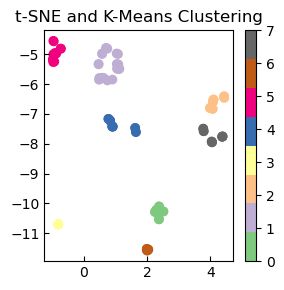

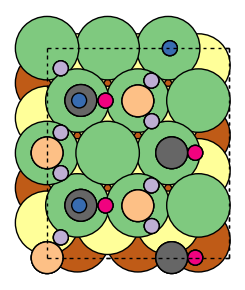

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from ase.visualize.plot import plot_atoms

color_set = "Accent"

tsne = TSNE(n_components=2, perplexity=50, random_state=456)
t_X = tsne.fit_transform(captured_outputs[2])

kmeans = KMeans(n_clusters=8, random_state=456)
kmeans.fit(t_X)
labels = kmeans.labels_

fig1, ax1 = plt.subplots(figsize=(3, 3))
scatter = ax1.scatter(t_X[:, 0], t_X[:, 1], c=labels, cmap=color_set)
fig1.colorbar(scatter, ax=ax1, orientation='vertical')
ax1.set_title('t-SNE and K-Means Clustering')
ax1.tick_params(direction='in')

plt.tight_layout()
plt.savefig('tsne_kmeans_plot1.svg', format='svg', bbox_inches='tight')

fig2, ax2 = plt.subplots(figsize=(3, 3))

cmap = plt.get_cmap(color_set)
norm = Normalize(vmin=labels.min(), vmax=labels.max())
sm = ScalarMappable(norm=norm, cmap=cmap)
mapped_colors = sm.to_rgba(labels)

plot_atoms(atoms=atoms, colors=mapped_colors, ax=ax2)
ax2.axis('off') 

plt.tight_layout()
plt.savefig('tsne_kmeans_plot2.svg', format='svg', bbox_inches='tight')

plt.show()

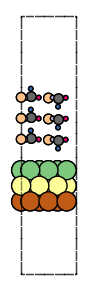

In [12]:
fig2, ax2 = plt.subplots(figsize=(3, 3))

cmap = plt.get_cmap(color_set)
norm = Normalize(vmin=labels.min(), vmax=labels.max())
sm = ScalarMappable(norm=norm, cmap=cmap)
mapped_colors = sm.to_rgba(labels)

plot_atoms(atoms=atoms, colors=mapped_colors, ax=ax2, rotation="-90x")
ax2.axis('off')

plt.tight_layout()

plt.savefig('tsne_kmeans_plot3.svg', format='svg', bbox_inches='tight')

plt.show()

In [4]:
model = ml_calc.trainer.model.module

In [10]:
for name, parameter in model.named_parameters():
    param_count = parameter.numel()
    print(f"{name}: {param_count}")

mlp_rbf3.linear.weight: 2048
mlp_cbf3.weight: 14336
mlp_rbf_h.linear.weight: 2048
mlp_rbf_out.linear.weight: 2048
atom_emb.embeddings.weight: 42496
edge_emb.dense.linear.weight: 589824
out_blocks.0.dense_rbf.linear.weight: 8192
out_blocks.0.scale_sum.scale_factor: 1
out_blocks.0.layers.0.linear.weight: 262144
out_blocks.0.layers.1.dense_mlp.0.linear.weight: 262144
out_blocks.0.layers.1.dense_mlp.1.linear.weight: 262144
out_blocks.0.layers.2.dense_mlp.0.linear.weight: 262144
out_blocks.0.layers.2.dense_mlp.1.linear.weight: 262144
out_blocks.0.layers.3.dense_mlp.0.linear.weight: 262144
out_blocks.0.layers.3.dense_mlp.1.linear.weight: 262144
out_blocks.0.out_energy.linear.weight: 512
out_blocks.0.scale_rbf_F.scale_factor: 1
out_blocks.0.seq_forces.0.linear.weight: 262144
out_blocks.0.seq_forces.1.dense_mlp.0.linear.weight: 262144
out_blocks.0.seq_forces.1.dense_mlp.1.linear.weight: 262144
out_blocks.0.seq_forces.2.dense_mlp.0.linear.weight: 262144
out_blocks.0.seq_forces.2.dense_mlp.1.lin

In [5]:
def get_parameters_count(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    
    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")
    print(f"Non-trainable parameters: {non_trainable_params}")

get_parameters_count(model)

Total parameters: 31671825
Trainable parameters: 5531139
Non-trainable parameters: 26140686


In [6]:
def get_parameters_by_prefix(model, prefix):
    total_params = 0
    for name, parameter in model.named_parameters():
        if name.startswith(prefix):
            param_count = parameter.numel()
            total_params += param_count
            print(f"{name}: {param_count} parameters")
    print(f"Total parameters in layers starting with '{prefix}': {total_params}")

get_parameters_by_prefix(model, 'out_blocks.0')

out_blocks.0.dense_rbf.linear.weight: 8192 parameters
out_blocks.0.scale_sum.scale_factor: 1 parameters
out_blocks.0.layers.0.linear.weight: 262144 parameters
out_blocks.0.layers.1.dense_mlp.0.linear.weight: 262144 parameters
out_blocks.0.layers.1.dense_mlp.1.linear.weight: 262144 parameters
out_blocks.0.layers.2.dense_mlp.0.linear.weight: 262144 parameters
out_blocks.0.layers.2.dense_mlp.1.linear.weight: 262144 parameters
out_blocks.0.layers.3.dense_mlp.0.linear.weight: 262144 parameters
out_blocks.0.layers.3.dense_mlp.1.linear.weight: 262144 parameters
out_blocks.0.out_energy.linear.weight: 512 parameters
out_blocks.0.scale_rbf_F.scale_factor: 1 parameters
out_blocks.0.seq_forces.0.linear.weight: 262144 parameters
out_blocks.0.seq_forces.1.dense_mlp.0.linear.weight: 262144 parameters
out_blocks.0.seq_forces.1.dense_mlp.1.linear.weight: 262144 parameters
out_blocks.0.seq_forces.2.dense_mlp.0.linear.weight: 262144 parameters
out_blocks.0.seq_forces.2.dense_mlp.1.linear.weight: 262144 p

In [7]:
def get_parameter_count(model):
    print("Layer-wise parameter count:")
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        param = parameter.numel()
        total_params += param
        print(f"{name}: {param}")
    print(f"Total trainable parameters: {total_params}")

get_parameter_count(model)


Layer-wise parameter count:
out_blocks.1.scale_rbf_F.scale_factor: 1
out_blocks.1.seq_forces.0.linear.weight: 262144
out_blocks.1.seq_forces.1.dense_mlp.0.linear.weight: 262144
out_blocks.1.seq_forces.1.dense_mlp.1.linear.weight: 262144
out_blocks.1.seq_forces.2.dense_mlp.0.linear.weight: 262144
out_blocks.1.seq_forces.2.dense_mlp.1.linear.weight: 262144
out_blocks.1.seq_forces.3.dense_mlp.0.linear.weight: 262144
out_blocks.1.seq_forces.3.dense_mlp.1.linear.weight: 262144
out_blocks.1.out_forces.linear.weight: 512
out_blocks.1.dense_rbf_F.linear.weight: 8192
out_blocks.2.scale_rbf_F.scale_factor: 1
out_blocks.2.seq_forces.0.linear.weight: 262144
out_blocks.2.seq_forces.1.dense_mlp.0.linear.weight: 262144
out_blocks.2.seq_forces.1.dense_mlp.1.linear.weight: 262144
out_blocks.2.seq_forces.2.dense_mlp.0.linear.weight: 262144
out_blocks.2.seq_forces.2.dense_mlp.1.linear.weight: 262144
out_blocks.2.seq_forces.3.dense_mlp.0.linear.weight: 262144
out_blocks.2.seq_forces.3.dense_mlp.1.linear.w